In [5]:
#1. TIME SERIES PLOT FOR SELECTED STATIONS FOR DIFFERENT RELAXATION TIMES.
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os,sys
import datetime
plt.style.use('seaborn-poster')

knmipath = '/nobackup/users/killaars/PhD_data/benchmarkrun_2014/'
macbookpath = '/Users/killaars/PhD/2017_nudging_coupling_test/benchmarkrun_2014/'
path = macbookpath


fin_obs = []
time = []
obs_num = []
obs_id = []
obs_loc = []
lat = []
lon = []
alt = []
fn3c3_obs = []
fn311_obs = []
for root, dirs, files in os.walk(os.path.join(path,'sample_flasks')):
    for file in sorted(files):
        if file.startswith('sample_coordinates_201401'):
            #print(file,file[19:])
            #print('flask_output_TM5_MP_'+file[19:])            
            #print('flask_output_ECE_'+file[19:])
            ECE_filename = 'flask_output_ECE_'+file[19:]
            
            flask_in = os.path.join(path,'sample_flasks',file)
            flask_n3c3 = os.path.join(path,'n3c3',ECE_filename)
            flask_n311 = os.path.join(path,'n311',ECE_filename)

            flask_in_fh = nc.Dataset(flask_in,mode='r')
            flask_n3c3_fh = nc.Dataset(flask_n3c3,mode='r')
            flask_n311_fh = nc.Dataset(flask_n311,mode='r')
            
            x = 40000000
            fin_obs = np.append(fin_obs,flask_in_fh.variables['observed'][:x])
            fin_date = flask_in_fh.variables['date_components'][:x]
            obs_num = np.append(obs_num,flask_in_fh.variables['obs_num'][:x])
            obs_id = np.append(obs_id,nc.chartostring(flask_in_fh.variables['obs_id'][:])) 
            lat = np.append(lat,flask_in_fh.variables['latitude'][:x])
            lon = np.append(lon,flask_in_fh.variables['longitude'][:x])
            alt = np.append(alt,flask_in_fh.variables['altitude'][:x])
            fn3c3_obs = np.append(fn3c3_obs,flask_n3c3_fh.variables['flask'][:x,0])
            fn311_obs = np.append(fn311_obs,flask_n311_fh.variables['flask'][:x,0])
            
            flask_in_fh.close()
            flask_n3c3_fh.close()
            flask_n311_fh.close()

            #check if the shapes are similar, meaning that they have the same number of points
            #print(np.shape(fin_obs),np.shape(fmp_obs0),np.shape(fn1c3_obs))
            
            #Code to transform the date components of the input file to a pandas series of timestamps
            N = (len(fin_date))
            base = datetime.datetime(1900, 1, 1)
            time_intermediate = np.array([base + datetime.timedelta(hours=i) for i in range(N)])
            for i in range(N):
                dt = datetime.datetime(fin_date[i,0],fin_date[i,1],fin_date[i,2],fin_date[i,3],fin_date[i,4],fin_date[i,5])
                time_intermediate[i] = pd.Timestamp(dt)
            time = np.append(time,time_intermediate)        
temp_array=[]
for i in range(len(obs_id)):
    string = str(obs_id[i])
    obs_loc.append(string[51:54])
    if 'surface-flask' in string:
        temp_array.append('surface-flask')
    elif 'surface-insitu' in str(string):
        temp_array.append('surface-insitu')
    elif 'aircraft-insitu' in str(string):
        temp_array.append('aircraft-insitu')
    elif 'tower-insitu' in str(string):
        temp_array.append('tower-insitu')
    elif 'aircraft-pfp' in str(string):
        temp_array.append('aircraft-pfp')
    elif 'surface-pfp' in str(string):
        temp_array.append('surface-pfp')
    elif 'aircraft-flask' in str(string):
        temp_array.append('aircraft-flask')
    elif 'shipboard-flask' in str(string):
        temp_array.append('shipboard-flask')
obs_id=temp_array

df = pd.DataFrame({'A_fin_obs' : fin_obs*1000000,
                   'B_fn3c3_obs' : fn3c3_obs*1000000,
                   'C_fn311_obs': fn311_obs*1000000,
                   'D_alt'     : alt,
                   'E_lat'     : lat,
                   'F_lon'     : lon,
                   'G_date'    : time,
                   'H_obs_id'  : obs_id,
                   'I_obs_loc' : obs_loc},index=obs_num)

df['Y_n3c3minusobs']=df['B_fn3c3_obs']-df['A_fin_obs']
df['Z_n311minusobs']=df['C_fn311_obs']-df['A_fin_obs']



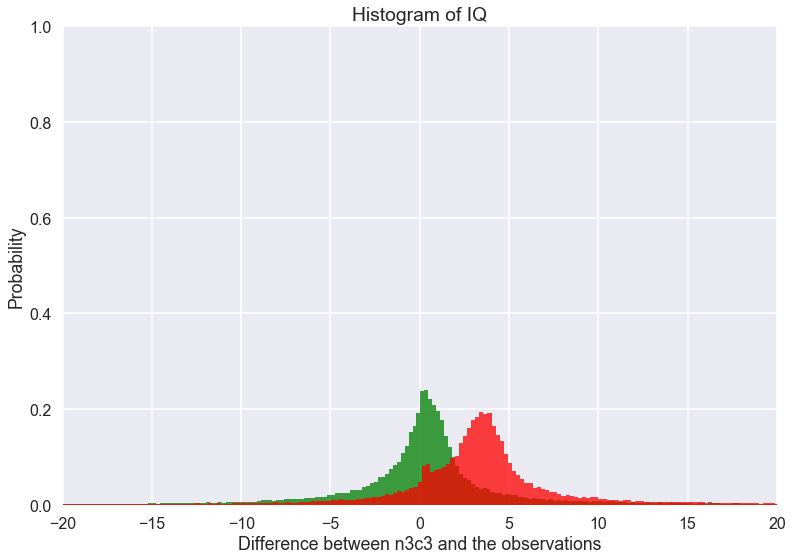

In [20]:
#mask_loc = 'lef'
#mask = (df.I_obs_loc==mask_loc)

# the histogram of the data
n, bins, patches = plt.hist(df['Y_n3c3minusobs'], 500, normed=1, facecolor='g', alpha=0.75)
n, bins, patches = plt.hist(df['Z_n311minusobs'], 500, normed=1, facecolor='r', alpha=0.75)
plt.xlabel('Difference between n3c3 and the observations')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.axis([-20, 20,0,1])
plt.grid(True)
plt.show()
